In [2]:
import numpy as np
import random
import pandas as pd
import joblib
import os

In [3]:
from collections import defaultdict
import datatable as dt
import lightgbm as lgb
from matplotlib import pyplot as plt
# import riiideducation
from sklearn.metrics import roc_auc_score
import gc

_ = np.seterr(divide='ignore', invalid='ignore')

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [4]:
# Initial value
SEED = 123

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(SEED)

# Preprocess

In [5]:
data_types_dict = {
    'timestamp': 'int64',
    'user_id': 'int32', 
    'content_id': 'int16', 
    'content_type_id':'int8', 
    'task_container_id': 'int16',
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}
target = 'answered_correctly'

In [6]:
print('start read train data...')
train_df = dt.fread('../input/riiid-test-answer-prediction/train.csv', columns=set(data_types_dict.keys())).to_pandas()

start read train data...


In [7]:
print('start handle lecture data...')

start handle lecture data...


In [8]:
#reading in lecture df
lectures_df = pd.read_csv('../input/riiid-test-answer-prediction/lectures.csv')

In [9]:
lectures_df['type_of'] = lectures_df['type_of'].replace('solving question', 'solving_question')

lectures_df = pd.get_dummies(lectures_df, columns=['part', 'type_of'])

part_lectures_columns = [column for column in lectures_df.columns if column.startswith('part')]

types_of_lectures_columns = [column for column in lectures_df.columns if column.startswith('type_of_')]

In [10]:
train_lectures = train_df[train_df.content_type_id == True].merge(lectures_df, left_on='content_id', right_on='lecture_id', how='left')

In [11]:
user_lecture_stats_part = train_lectures.groupby('user_id',as_index = False)[part_lectures_columns + types_of_lectures_columns].sum()

In [12]:
lecturedata_types_dict = {   
    'user_id': 'int32', 
    'part_1': 'int8',
    'part_2': 'int8',
    'part_3': 'int8',
    'part_4': 'int8',
    'part_5': 'int8',
    'part_6': 'int8',
    'part_7': 'int8',
    'type_of_concept': 'int8',
    'type_of_intention': 'int8',
    'type_of_solving_question': 'int8',
    'type_of_starter': 'int8'
}
user_lecture_stats_part = user_lecture_stats_part.astype(lecturedata_types_dict)

In [13]:
for column in user_lecture_stats_part.columns:
    #bool_column = column + '_boolean'
    if(column !='user_id'):
        user_lecture_stats_part[column] = (user_lecture_stats_part[column] > 0).astype('int8')

In [14]:
user_lecture_stats_part.dtypes

user_id                     int32
part_1                       int8
part_2                       int8
part_3                       int8
part_4                       int8
part_5                       int8
part_6                       int8
part_7                       int8
type_of_concept              int8
type_of_intention            int8
type_of_solving_question     int8
type_of_starter              int8
dtype: object

In [15]:
#clearing memory
del(train_lectures)
gc.collect()

88

In [16]:
user_lecture_agg = train_df.groupby('user_id')['content_type_id'].agg(['sum', 'count'])
user_lecture_agg=user_lecture_agg.astype('int16')

In [17]:

#1= if the event was the user watching a lecture.
cum = train_df.groupby('user_id')['content_type_id'].agg(['cumsum', 'cumcount'])
cum['cumcount']=cum['cumcount']+1
train_df['user_interaction_count'] = cum['cumcount'] 
train_df['user_interaction_timestamp_mean'] = train_df['timestamp']/cum['cumcount'] 
train_df['user_lecture_sum'] = cum['cumsum'] 
train_df['user_lecture_lv'] = cum['cumsum'] / cum['cumcount']


train_df.user_lecture_lv=train_df.user_lecture_lv.astype('float16')
train_df.user_lecture_sum=train_df.user_lecture_sum.astype('int16')
train_df.user_interaction_count=train_df.user_interaction_count.astype('int16')
train_df['user_interaction_timestamp_mean']=train_df['user_interaction_timestamp_mean']/(1000*3600)
train_df.user_interaction_timestamp_mean=train_df.user_interaction_timestamp_mean.astype('float32')


In [19]:
del cum
gc.collect()

88

In [20]:
print('start handle train_df...')

start handle train_df...


In [21]:
train_df['prior_question_had_explanation'].fillna(False, inplace=True)
train_df = train_df.astype(data_types_dict)
train_df = train_df[train_df[target] != -1].reset_index(drop=True)

In [22]:
content_explation_agg=train_df[["content_id","prior_question_had_explanation",target]].groupby(["content_id","prior_question_had_explanation"])[target].agg(['mean'])

In [23]:
content_explation_agg.dtypes

mean    float64
dtype: object

In [24]:
content_explation_agg=content_explation_agg.unstack()

content_explation_agg=content_explation_agg.reset_index()
content_explation_agg.columns = ['content_id', 'content_explation_false_mean','content_explation_true_mean']

In [25]:
content_explation_agg.content_id=content_explation_agg.content_id.astype('int16')
content_explation_agg.content_explation_false_mean=content_explation_agg.content_explation_false_mean.astype('float16')
content_explation_agg.content_explation_true_mean=content_explation_agg.content_explation_true_mean.astype('float16')

In [26]:
print('start handle attempt_no...')

start handle attempt_no...


In [27]:

train_df["attempt_no"] = 1
train_df.attempt_no=train_df.attempt_no.astype('int8')
#
attempt_no_agg=train_df.groupby(["user_id","content_id"])["attempt_no"].agg(['sum']).astype('int8')
#attempt_no_agg=attempt_no_agg.astype('int8')
train_df["attempt_no"] = train_df[["user_id","content_id",'attempt_no']].groupby(["user_id","content_id"])["attempt_no"].cumsum()

In [28]:
#attempt_no_agg=attempt_no_agg.reset_index()
attempt_no_agg=attempt_no_agg[attempt_no_agg['sum'] >1]

In [29]:
print('start handle timestamp...')
prior_question_elapsed_time_mean=train_df['prior_question_elapsed_time'].mean()
train_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace=True)

start handle timestamp...


In [85]:
prior_question_elapsed_time_mean

13005.0810546875

In [30]:
max_timestamp_u = train_df[['user_id','timestamp']].groupby(['user_id']).agg(['max']).reset_index()
max_timestamp_u.columns = ['user_id', 'max_time_stamp']
max_timestamp_u.user_id=max_timestamp_u.user_id.astype('int32')

In [31]:

train_df['lagtime'] = train_df.groupby('user_id')['timestamp'].shift()

max_timestamp_u2 = train_df[['user_id','lagtime']].groupby(['user_id']).agg(['max']).reset_index()
max_timestamp_u2.columns = ['user_id', 'max_time_stamp2']
max_timestamp_u2.user_id=max_timestamp_u2.user_id.astype('int32')

In [32]:
train_df['lagtime']=train_df['timestamp']-train_df['lagtime']
lagtime_mean=train_df['lagtime'].mean()
train_df['lagtime'].fillna(lagtime_mean, inplace=True)

In [33]:
train_df['lagtime']=train_df['lagtime']/(1000*3600)
train_df.lagtime=train_df.lagtime.astype('float32')

In [34]:
# lagtime_agg = train_df.groupby('user_id')['lagtime'].agg(['mean'])
# train_df['lagtime_mean'] = train_df['user_id'].map(lagtime_agg['mean'])
# train_df.lagtime_mean=train_df.lagtime_mean.astype('int32')
# lagtime_agg=lagtime_agg.astype('int32')

In [35]:

train_df['lagtime2'] = train_df.groupby('user_id')['timestamp'].shift(2)

max_timestamp_u3 = train_df[['user_id','lagtime2']].groupby(['user_id']).agg(['max']).reset_index()
max_timestamp_u3.columns = ['user_id', 'max_time_stamp3']
max_timestamp_u3.user_id=max_timestamp_u3.user_id.astype('int32')

train_df['lagtime2']=train_df['timestamp']-train_df['lagtime2']
lagtime_mean2=train_df['lagtime2'].mean()
train_df['lagtime2'].fillna(lagtime_mean2, inplace=True)

In [36]:
train_df['lagtime2']=train_df['lagtime2']/(1000*3600)
train_df.lagtime2=train_df.lagtime2.astype('float32')

In [37]:
train_df['lagtime3'] = train_df.groupby('user_id')['timestamp'].shift(3)

train_df['lagtime3']=train_df['timestamp']-train_df['lagtime3']
lagtime_mean3=train_df['lagtime3'].mean()
train_df['lagtime3'].fillna(lagtime_mean3, inplace=True)
train_df['lagtime3']=train_df['lagtime3']/(1000*3600)
train_df.lagtime3=train_df.lagtime3.astype('float32')

In [39]:
train_df['timestamp']=train_df['timestamp']/(1000*3600)
train_df.timestamp=train_df.timestamp.astype('float16')

In [40]:
user_prior_question_elapsed_time = train_df[['user_id','prior_question_elapsed_time']].groupby(['user_id']).tail(1)
user_prior_question_elapsed_time.columns = ['user_id', 'prior_question_elapsed_time']

In [41]:
train_df['delta_prior_question_elapsed_time'] = train_df.groupby('user_id')['prior_question_elapsed_time'].shift()
train_df['delta_prior_question_elapsed_time']=train_df['prior_question_elapsed_time']-train_df['delta_prior_question_elapsed_time']

In [42]:
delta_prior_question_elapsed_time_mean=train_df['delta_prior_question_elapsed_time'].mean()
train_df['delta_prior_question_elapsed_time'].fillna(delta_prior_question_elapsed_time_mean, inplace=True)
train_df.delta_prior_question_elapsed_time=train_df.delta_prior_question_elapsed_time.astype('int32')

In [43]:
train_df['lag'] = train_df.groupby('user_id')[target].shift()

cum = train_df.groupby('user_id')['lag'].agg(['cumsum', 'cumcount'])
user_agg = train_df.groupby('user_id')['lag'].agg(['sum', 'count']).astype('int16')
cum['cumsum'].fillna(0, inplace=True)

train_df['user_correctness'] = cum['cumsum'] / cum['cumcount']
train_df['user_correct_count'] = cum['cumsum']
train_df['user_uncorrect_count'] = cum['cumcount']-cum['cumsum']
train_df.drop(columns=['lag'], inplace=True)
train_df['user_correctness'].fillna(0.67, inplace=True)
train_df.user_correctness=train_df.user_correctness.astype('float16')
train_df.user_correct_count=train_df.user_correct_count.astype('int16')
train_df.user_uncorrect_count=train_df.user_uncorrect_count.astype('int16')

In [44]:
del cum
gc.collect()

22

In [46]:
train_df.prior_question_had_explanation=train_df.prior_question_had_explanation.astype('int8')
explanation_agg = train_df.groupby('user_id')['prior_question_had_explanation'].agg(['sum', 'count'])
explanation_agg=explanation_agg.astype('int16')

In [47]:
cum = train_df.groupby('user_id')['prior_question_had_explanation'].agg(['cumsum', 'cumcount'])
cum['cumcount']=cum['cumcount']+1
train_df['explanation_mean'] = cum['cumsum'] / cum['cumcount']
train_df['explanation_true_count'] = cum['cumsum'] 
train_df['explanation_false_count'] =  cum['cumcount']-cum['cumsum']

train_df.explanation_mean=train_df.explanation_mean.astype('float16')
train_df.explanation_true_count=train_df.explanation_true_count.astype('int16')
train_df.explanation_false_count=train_df.explanation_false_count.astype('int16')

In [48]:
del cum
gc.collect()

35

In [49]:
content_agg = train_df.groupby('content_id')[target].agg(['sum', 'count','var'])
task_container_agg = train_df.groupby('task_container_id')[target].agg(['sum', 'count','var'])
content_agg=content_agg.astype('float32')
task_container_agg=task_container_agg.astype('float32')

In [50]:
train_df['task_container_uncor_count'] = train_df['task_container_id'].map(task_container_agg['count']-task_container_agg['sum']).astype('int32')
train_df['task_container_cor_count'] = train_df['task_container_id'].map(task_container_agg['sum']).astype('int32')
train_df['task_container_std'] = train_df['task_container_id'].map(task_container_agg['var']).astype('float16')
train_df['task_container_correctness'] = train_df['task_container_id'].map(task_container_agg['sum'] / task_container_agg['count'])
train_df.task_container_correctness=train_df.task_container_correctness.astype('float16')

In [51]:
content_elapsed_time_agg=train_df.groupby('content_id')['prior_question_elapsed_time'].agg(['mean'])
content_had_explanation_agg=train_df.groupby('content_id')['prior_question_had_explanation'].agg(['mean'])

In [52]:
train_df.dtypes

timestamp                            float16
user_id                                int32
content_id                             int16
content_type_id                         int8
task_container_id                      int16
answered_correctly                      int8
prior_question_elapsed_time          float32
prior_question_had_explanation          int8
user_interaction_count                 int16
user_interaction_timestamp_mean      float32
user_lecture_sum                       int16
user_lecture_lv                      float16
attempt_no                              int8
lagtime                              float32
lagtime2                             float32
lagtime3                             float32
delta_prior_question_elapsed_time      int32
user_correctness                     float16
user_correct_count                     int16
user_uncorrect_count                   int16
explanation_mean                     float16
explanation_true_count                 int16
explanatio

In [53]:
train_df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_interaction_count,user_interaction_timestamp_mean,...,user_correctness,user_correct_count,user_uncorrect_count,explanation_mean,explanation_true_count,explanation_false_count,task_container_uncor_count,task_container_cor_count,task_container_std,task_container_correctness
0,0.000000,115,5692,0,1,1,13005.081055,0,1,0.000000,...,0.669922,0,0,0.0,0,1,187175,208704,0.249268,0.527344
1,0.015823,115,5716,0,2,1,37000.000000,0,2,0.007909,...,1.000000,1,0,0.0,0,2,223198,172342,0.245850,0.435791
2,0.032867,115,128,0,0,1,55000.000000,0,3,0.010960,...,1.000000,2,0,0.0,0,3,126682,269233,0.217651,0.680176
3,0.036438,115,7860,0,3,1,19000.000000,0,4,0.009109,...,1.000000,3,0,0.0,0,4,180574,214721,0.248169,0.542969
4,0.038330,115,7922,0,4,1,11000.000000,0,5,0.007665,...,1.000000,4,0,0.0,0,5,361957,330079,0.249512,0.477051


In [54]:
print('start questions data...')

start questions data...


In [55]:
questions_df = pd.read_csv(
    '../input/riiid-test-answer-prediction/questions.csv', 
    usecols=[0, 1,3,4],
    dtype={'question_id': 'int16','bundle_id': 'int16', 'part': 'int8','tags': 'str'}
)

In [56]:
bundle_agg = questions_df.groupby('bundle_id')['question_id'].agg(['count'])

In [57]:
questions_df['content_sub_bundle'] = questions_df['bundle_id'].map(bundle_agg['count']).astype('int8')

In [58]:
questions_df['tags'].fillna('188', inplace=True)

In [59]:
def gettags(tags,num):
    tags_splits=tags.split(" ")
    result='' 
    for t in tags_splits:
        x=int(t)
        if(x<32*(num+1) and x>=32*num):#num 
            result=result+' '+t
    return result

In [60]:
from sklearn.preprocessing import LabelEncoder
for num in range(0,6):
    questions_df["tags"+str(num)] = questions_df["tags"].apply(lambda row: gettags(row,num))
    le = LabelEncoder()
    le.fit(np.unique(questions_df['tags'+str(num)].values))
    #questions_df[['tags'+str(num)]=
    questions_df['tags'+str(num)]=questions_df[['tags'+str(num)]].apply(le.transform)

In [61]:
questions_df_dict = {   
    'tags0': 'int8',
    'tags1': 'int8',
    'tags2': 'int8',
    'tags3': 'int8',
    'tags4': 'int8',
    'tags5': 'int8',
}
questions_df = questions_df.astype(questions_df_dict)

In [62]:
questions_df.drop(columns=['tags'], inplace=True)

In [63]:
questions_df['part_bundle_id']=questions_df['part']*100000+questions_df['bundle_id']
questions_df.part_bundle_id=questions_df.part_bundle_id.astype('int32')

In [66]:
questions_df.rename(columns={'question_id':'content_id'}, inplace=True)

In [67]:
questions_df = pd.merge(questions_df, content_explation_agg, on='content_id', how='left',right_index=True)#

In [68]:
del content_explation_agg

In [69]:
questions_df['content_correctness'] = questions_df['content_id'].map(content_agg['sum'] / content_agg['count'])
questions_df.content_correctness=questions_df.content_correctness.astype('float16')
questions_df['content_correctness_std'] = questions_df['content_id'].map(content_agg['var'])
questions_df.content_correctness_std=questions_df.content_correctness_std.astype('float16')
questions_df['content_uncorrect_count'] = questions_df['content_id'].map(content_agg['count']-content_agg['sum']).astype('int32')
questions_df['content_correct_count'] = questions_df['content_id'].map(content_agg['sum']).astype('int32')

In [70]:
questions_df['content_elapsed_time_mean'] = questions_df['content_id'].map(content_elapsed_time_agg['mean'])
questions_df.content_elapsed_time_mean=questions_df.content_elapsed_time_mean.astype('float16')
questions_df['content_had_explanation_mean'] = questions_df['content_id'].map(content_had_explanation_agg['mean'])
questions_df.content_had_explanation_mean=questions_df.content_had_explanation_mean.astype('float16')

In [71]:
del content_elapsed_time_agg
del content_had_explanation_agg
gc.collect()

101

In [72]:
part_agg = questions_df.groupby('part')['content_correctness'].agg(['mean', 'var'])
questions_df['part_correctness_mean'] = questions_df['part'].map(part_agg['mean'])
questions_df['part_correctness_std'] = questions_df['part'].map(part_agg['var'])
questions_df.part_correctness_mean=questions_df.part_correctness_mean.astype('float16')
questions_df.part_correctness_std=questions_df.part_correctness_std.astype('float16')

In [73]:
part_agg = questions_df.groupby('part')['content_uncorrect_count'].agg(['sum'])
questions_df['part_uncor_count'] = questions_df['part'].map(part_agg['sum']).astype('int32')
part_agg = questions_df.groupby('part')['content_correct_count'].agg(['sum'])
questions_df['part_cor_count'] = questions_df['part'].map(part_agg['sum']).astype('int32')

In [74]:
bundle_agg = questions_df.groupby('bundle_id')['content_correctness'].agg(['mean'])
questions_df['bundle_correctness_mean'] = questions_df['bundle_id'].map(bundle_agg['mean'])
questions_df.bundle_correctness_mean=questions_df.bundle_correctness_mean.astype('float16')

In [77]:
questions_df.dtypes

content_id                        int16
bundle_id                         int16
part                               int8
content_sub_bundle                 int8
tags0                              int8
tags1                              int8
tags2                              int8
tags3                              int8
tags4                              int8
tags5                              int8
part_bundle_id                    int32
content_explation_false_mean    float16
content_explation_true_mean     float16
content_correctness             float16
content_correctness_std         float16
content_uncorrect_count           int32
content_correct_count             int32
content_elapsed_time_mean       float16
content_had_explanation_mean    float16
part_correctness_mean           float16
part_correctness_std            float16
part_uncor_count                  int32
part_cor_count                    int32
bundle_correctness_mean         float16
dtype: object

In [78]:
del content_agg
del bundle_agg
del part_agg
gc.collect()

22

In [81]:
len(train_df)

99271300

## Save dataframes

In [90]:
prior_question_elapsed_time_mean

13005.0810546875

In [86]:
lagtime_mean

20441941.566456214

In [87]:
lagtime_mean2

40370652.30368494

In [88]:
lagtime_mean3

60008399.99610778

In [89]:
delta_prior_question_elapsed_time_mean

44.682064056396484

In [83]:
%%time

train_df.to_pickle('../input/train-df2/train_df.pkl')

CPU times: user 4.8 s, sys: 13.8 s, total: 18.6 s
Wall time: 25.3 s


In [ ]:
%%time

questions_df.to_pickle('../input/train-df2/questions_df.pkl')
attempt_no_agg.to_pickle('../input/train-df2/attempt_no_agg.pkl')
explanation_agg.to_pickle('../input/train-df2/explanation_agg.pkl')
max_timestamp_u.to_pickle('../input/train-df2/max_timestamp_u.pkl')
max_timestamp_u2.to_pickle('../input/train-df2/max_timestamp_u2.pkl')
max_timestamp_u3.to_pickle('../input/train-df2/max_timestamp_u3.pkl')
task_container_agg.to_pickle('../input/train-df2/task_container_agg.pkl')
user_agg.to_pickle('../input/train-df2/user_agg.pkl')
user_lecture_agg.to_pickle('../input/train-df2/user_lecture_agg.pkl')
user_prior_question_elapsed_time.to_pickle('../input/train-df2/user_prior_question_elapsed_time.pkl')

# Train

In [7]:
features_dict = {
    'timestamp':'float16',#
    'user_interaction_count':'int16',
    'user_interaction_timestamp_mean':'float32',
    'lagtime':'float32',#
    'lagtime2':'float32',
    'lagtime3':'float32',
    'content_id':'int16',
    'task_container_id':'int16',
    'user_lecture_sum':'int16',#
    'user_lecture_lv':'float16',##
    'prior_question_elapsed_time':'float32',#
    'delta_prior_question_elapsed_time':'int32',#
    'user_correctness':'float16',#
    'user_uncorrect_count':'int16',#
    'user_correct_count':'int16',#
    'content_correctness_std':'float16',
    'content_correct_count':'int32',
    'content_uncorrect_count':'int32',#
    'content_elapsed_time_mean':'float16',
    'content_had_explanation_mean':'float16',
    'content_explation_false_mean':'float16',
    'content_explation_true_mean':'float16',
    'task_container_correctness':'float16',
    'task_container_std':'float16',
    'task_container_cor_count':'int32',#
    'task_container_uncor_count':'int32',#
    'attempt_no':'int8',#
    'part':'int8',
    'part_correctness_mean':'float16',
    'part_correctness_std':'float16',
    'part_uncor_count':'int32',
    'part_cor_count':'int32',
    'tags0': 'int8',
    'tags1': 'int8',
    'tags2': 'int8',
    'tags3': 'int8',
    'tags4': 'int8',
    'tags5': 'int8',
    'part_bundle_id':'int32',
    'content_sub_bundle':'int8',
    'prior_question_had_explanation':'int8',
    'explanation_mean':'float16', #
    'explanation_false_count':'int16',#
    'explanation_true_count':'int16',#
}
categorical_columns= [
    'content_id',
    'task_container_id',
    'part',
    'tags0',
    'tags1',
    'tags2',
    'tags3',
    'tags4',
    'tags5',
    'part_bundle_id',
    'content_sub_bundle',
    'prior_question_had_explanation', 
]

features=list(features_dict.keys())

In [8]:
len(features)

44

In [9]:
flag_lgbm=True

params = {
    'num_leaves': 200,
    'max_bin':450,
    'min_child_weight': 0.03454472573214212,
    'feature_fraction': 0.52,
    'bagging_fraction': 0.52,
    'min_data_in_leaf': 106,
    'objective': 'binary',
    'learning_rate': 0.05,
    "boosting_type": "gbdt",
    "metric": 'auc',
    "bagging_seed": 11,
    "verbosity": -1,
    'reg_alpha': 0.3899927210061127,
    'reg_lambda': 0.6485237330340494,
    'random_state': 47
}

In [10]:
users=train_df['user_id'].drop_duplicates()
users=users.sample(frac=0.08, random_state = SEED)
users_df=pd.DataFrame()
users_df['user_id']=users.values

valid_df_newuser = pd.merge(train_df, users_df, on=['user_id'], how='inner',right_index=True)
del users_df
del users
gc.collect()

train_df.drop(valid_df_newuser.index, inplace=True)
print('pd.merge(train_df_clf, questions_df)')

train_df = pd.merge(train_df, questions_df, on='content_id', how='left',right_index=True)#
valid_df_newuser = pd.merge(valid_df_newuser, questions_df, on='content_id', how='left',right_index=True)#

print('valid_df')
valid_df=train_df.sample(frac=0.1)
train_df.drop(valid_df.index, inplace=True)

valid_df = valid_df.append(valid_df_newuser)
del valid_df_newuser
gc.collect()

print('train_df length：',len(train_df))
print('valid_df length：',len(valid_df))

X_train_np = train_df[features].values.astype(np.float32)
X_valid_np = valid_df[features].values.astype(np.float32)
tr_data = lgb.Dataset(X_train_np, label=train_df[target], feature_name=list(features))
va_data = lgb.Dataset(X_valid_np, label=valid_df[target], feature_name=list(features))

del X_train_np
del X_valid_np
gc.collect()

model = lgb.train(
    params, 
    tr_data,
    num_boost_round=5000,
    valid_sets=[tr_data, va_data],
    early_stopping_rounds=50,
    feature_name=features,
    categorical_feature=categorical_columns,
    verbose_eval=5
)

model.save_model('model_1500.txt')

del tr_data
del va_data
del train_df
del valid_df
gc.collect()

pd.merge(train_df_clf, questions_df)
valid_df
train_df length： 82193120
valid_df length： 17078180


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['content_id', 'content_sub_bundle', 'part', 'part_bundle_id', 'prior_question_had_explanation', 'tags0', 'tags1', 'tags2', 'tags3', 'tags4', 'tags5', 'task_container_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds
[5]	training's auc: 0.755175	valid_1's auc: 0.755143
[10]	training's auc: 0.758004	valid_1's auc: 0.757971
[15]	training's auc: 0.760869	valid_1's auc: 0.760909
[20]	training's auc: 0.762402	valid_1's auc: 0.762433
[25]	training's auc: 0.762573	valid_1's auc: 0.762564
[30]	training's auc: 0.763264	valid_1's auc: 0.763248
[35]	training's auc: 0.764754	valid_1's auc: 0.764729
[40]	training's auc: 0.765857	valid_1's auc: 0.765794
[45]	training's auc: 0.76672	valid_1's auc: 0.766605
[50]	training's auc: 0.767686	valid_1's auc: 0.767548
[55]	training's auc: 0.768506	valid_1's auc: 0.768344
[60]	training's auc: 0.769311	valid_1's auc: 0.769126
[65]	training's auc: 0.769906	valid_1's auc: 0.769705
[70]	training's auc: 0.770618	valid_1's auc: 0.770368
[75]	training's auc: 0.771261	valid_1's auc: 0.77098
[80]	training's auc: 0.771778	valid_1's auc: 0.771473
[85]	training's auc: 0.772253	valid_1's auc: 0.771912
[90]	training's auc: 0.7

466

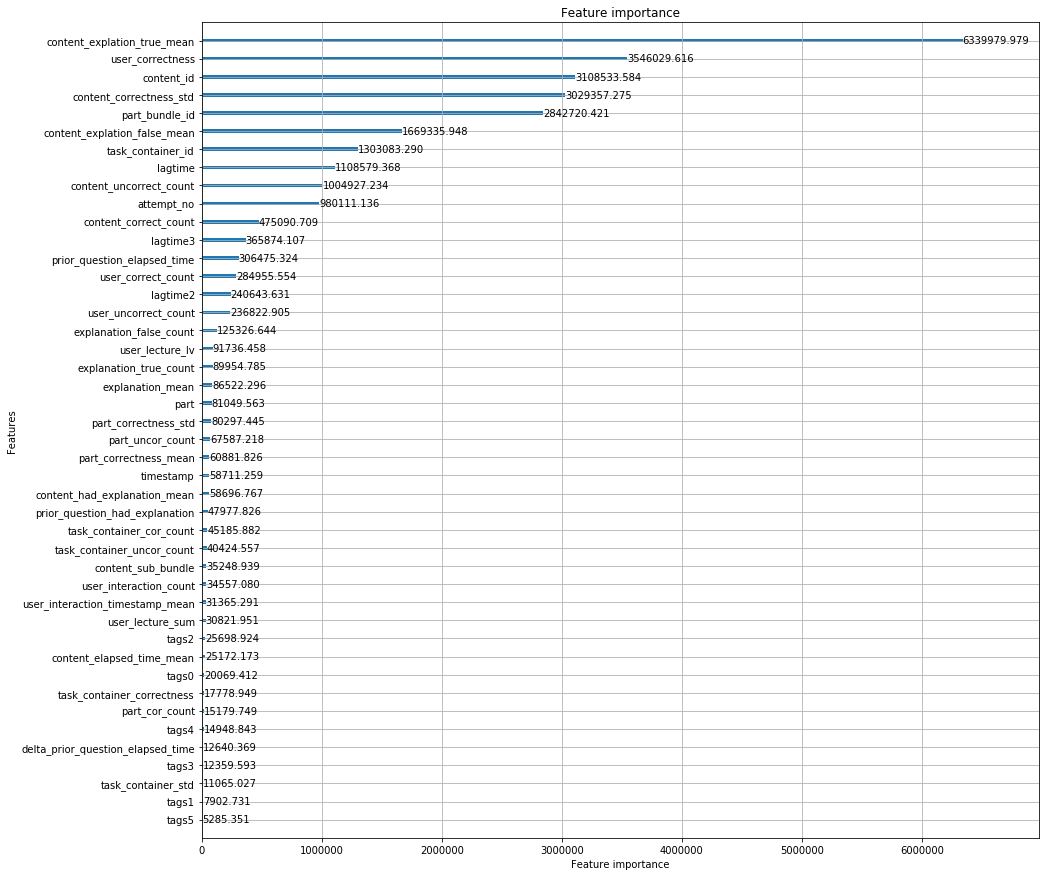

0

In [89]:
fig,ax = plt.subplots(figsize=(15,15))
lgb.plot_importance(model, ax=ax,importance_type='gain',max_num_features=50)
plt.show()

del tr_data
del va_data
gc.collect()